In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-22 13:28:07.878257: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-22 13:28:07.878274: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from ML_classes.MLPModel import MLPModel


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

max_value_energy = df["energy(kWh/hh)"].max()
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

In [5]:
# Initiating the class
deep_learner = MLPModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
layer_depths = [30,30],
layer_count= 2,
epochs = 20,
batch_size = 256,
train_test_split = 0.15
)

In [6]:
# Fitting the model

model = deep_learner.MLPModel()

Epoch 1/20


2022-03-22 13:28:11.223072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 13:28:11.223514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-22 13:28:11.223563: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-22 13:28:11.223606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-22 13:28:11.223646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

66/66 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0056
Epoch 2/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 3/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 4/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 5/20
66/66 [==============================] - 0s 962us/step - loss: 0.0049 - val_loss: 0.0049
Epoch 6/20
66/66 [==============================] - 0s 706us/step - loss: 0.0048 - val_loss: 0.0049
Epoch 7/20
66/66 [==============================] - 0s 999us/step - loss: 0.0048 - val_loss: 0.0048
Epoch 8/20
66/66 [==============================] - 0s 935us/step - loss: 0.0048 - val_loss: 0.0049
Epoch 9/20
66/66 [==============================] - 0s 964us/step - loss: 0.0048 - val_loss: 0.0048
Epoch 10/20
66/66 [==============================] - 0s 945us/step - loss: 0.0047 - val_loss: 0.0048
Epoch 11/20
66/66 

In [7]:
deep_learner.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                750       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,711
Trainable params: 1,711
Non-trainable params: 0
_________________________________________________________________


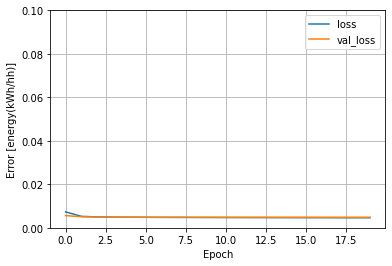

In [8]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [energy(kWh/hh)]')
    plt.legend()
    plt.grid(True)
plot_loss(deep_learner.history)

In [9]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.dc.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

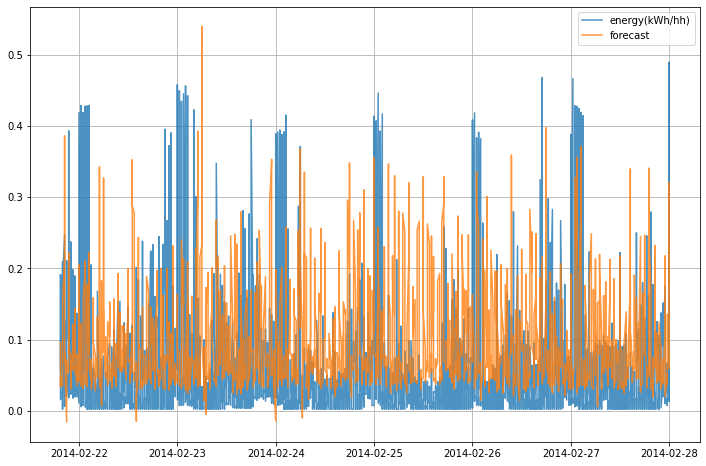

In [10]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_101468/2528746469.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


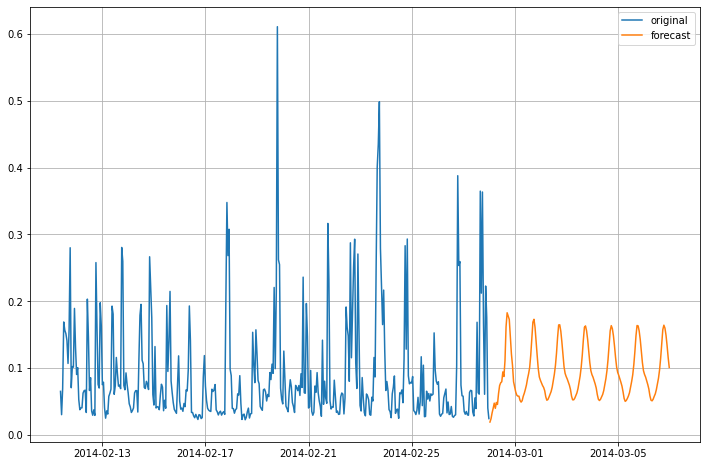

In [11]:

#Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [12]:
deep_learner.evaluateMSE()

0.004861112789517181

In [13]:
deep_learner.evaluateRMSE()

0.0697216809143123

In [14]:
deep_learner.evaluateMAE()

0.0417834969584897

In [15]:
deep_learner.evaluateMAPE()

45.942024891140186

In [16]:
yhat =deep_learner.predict()

In [17]:
yhat

[0.09636683,
 0.056046993,
 0.06391692,
 0.0474096,
 0.03335594,
 0.048814055,
 0.036546737,
 0.08127921,
 0.0573714,
 0.15165034,
 0.06565308,
 0.071600296,
 0.09237302,
 0.03537598,
 0.11384973,
 0.15170608,
 0.21369322,
 0.38602138,
 0.3707069,
 0.28184175,
 0.1644802,
 0.16273838,
 0.16267969,
 0.10139905,
 0.06713864,
 0.08259564,
 -0.015588029,
 0.03126466,
 0.06016267,
 0.040975023,
 0.012138743,
 0.053103156,
 0.047225084,
 0.059810217,
 0.06562113,
 0.07178949,
 0.052868545,
 0.14744182,
 0.22197299,
 0.18190666,
 0.09277208,
 0.14440705,
 0.08711157,
 0.10376937,
 0.11139731,
 0.088727325,
 0.080147445,
 0.049902614,
 0.048391536,
 0.03230024,
 0.031337243,
 0.044949003,
 0.044341784,
 0.03606323,
 0.07289446,
 0.07952808,
 0.06184995,
 0.059569947,
 0.057744883,
 0.087525524,
 0.12092162,
 0.0848221,
 0.0873616,
 0.06585199,
 0.09435363,
 0.06794981,
 0.07426447,
 0.11636057,
 0.059360515,
 0.09629158,
 0.14345129,
 0.08589873,
 0.07746702,
 0.06852641,
 0.05361033,
 0.06313

## 